# Zak Phase calculation for graphene nanoribbons

Let's make graphene and try to compute the Zak phase for different cell size and shape

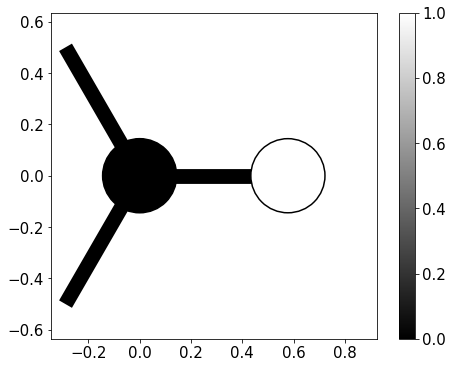

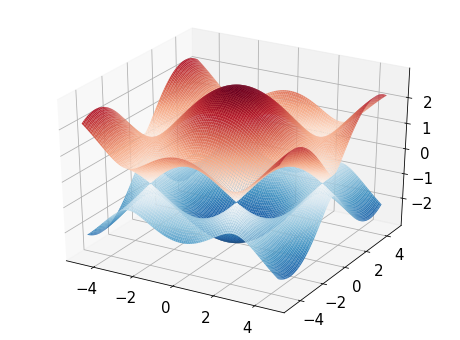

In [5]:
%run matplotlib_setup.ipy

from types import SimpleNamespace

from ipywidgets import interact
import matplotlib
from matplotlib import pyplot
from mpl_toolkits import mplot3d
import numpy as np
import scipy.linalg as la 

import kwant
from kwant.wraparound import wraparound, plot_2d_bands


def momentum_to_lattice(k):
    """Transform momentum to the basis of reciprocal lattice vectors.
    
    See https://en.wikipedia.org/wiki/Reciprocal_lattice#Generalization_of_a_dual_lattice
    """
    B = np.array(graphene.prim_vecs).T
    A = B.dot(np.linalg.inv(B.T.dot(B)))
    return np.linalg.solve(A, k)


def dispersion_2D(syst, args=None, lim=1.5*np.pi, num_points=200):
    """A simple plot of 2D band structure."""
    if args is None:
        args = []
    momenta = np.linspace(-lim, lim, num_points)
    energies = []
    for kx in momenta:
        for ky in momenta:
            lattice_k = momentum_to_lattice([kx, ky])
            h = syst.hamiltonian_submatrix(args=(list(args) + list(lattice_k)))
            energies.append(np.linalg.eigvalsh(h))
    
    energies = np.array(energies).reshape(num_points, num_points, -1)
    emin, emax = np.min(energies), np.max(energies)
    kx, ky = np.meshgrid(momenta, momenta)
    fig = pyplot.figure()
    axes = fig.add_subplot(1, 1, 1, projection='3d')
    for band in range(energies.shape[-1]):
        axes.plot_surface(kx, ky, energies[:, :, band], cstride=2, rstride=2,
                          cmap=matplotlib.cm.RdBu_r, vmin=emin, vmax=emax,
                          linewidth=0.1)
        
#Some helper functions to make the schematic look neat
def family_color(site): 
    if site.family == a: 
        return 0 
    else: 
        return 1
    
def hopping_lw(site1,site2): 
    return 0.1 if A in [site1.family,site2.family] else 0.05

graphene = kwant.lattice.general([[np.sqrt(3)/2,1/2],[np.sqrt(3)/2,-1/2]],  #Lattice vectors 
                                  [[0,0],[1/np.sqrt(3),0]]) # Co-ordinates
a,b = graphene.sublattices

bulk_graphene = kwant.Builder(kwant.TranslationalSymmetry(*graphene.prim_vecs))
bulk_graphene[graphene.shape((lambda pos: True), (0, 0))] = 0
bulk_graphene[graphene.neighbors(1)] = 1
kwant.plot(bulk_graphene,site_color=family_color,site_lw=0.01)
dispersion_2D(wraparound(bulk_graphene).finalized())

In [6]:
Zigzag = kwant.lattice.general([[1,0],[0,np.sqrt(3)/3]], #Lattice vectors
                                     [[1/6,0],[2/6,np.sqrt(3)/2],[4/6,np.sqrt(3)/2],[5/6,0]]) # Coordinates

def get_width(N): 
    if N < 2: 
        raise("N cannot be less than 2")
    else:
        return N/2*Zigzag.prim_vecs[1][1]+0.001

def make_1D_zigzag(N=7):
    syst = kwant.Builder(kwant.TranslationalSymmetry(Zigzag.prim_vecs[0]))
    syst[Zigzag.shape((lambda pos: pos[1] >0 and pos[1] < get_width(N)),(0,0))] = 0
    syst[Zigzag.neighbors()] = -1
    return syst

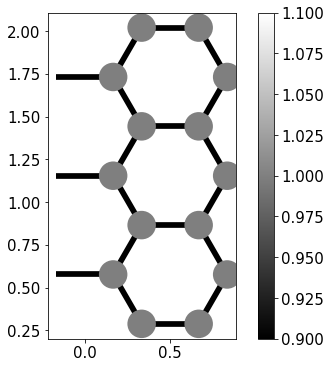

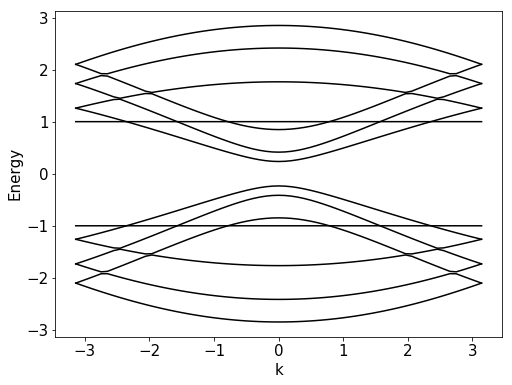

In [7]:
# Making a Zigzag lead
Zigzag_1d = make_1D_zigzag(N=7) 
kwant.plot(Zigzag_1d,site_color=family_color);
kwant.plotter.bands(Zigzag_1d.finalized());

# tbModel setup

In [4]:
import tbmodels 
import itertools 

model = tbmodels.Model(on_site=[1,-1],dim=1)

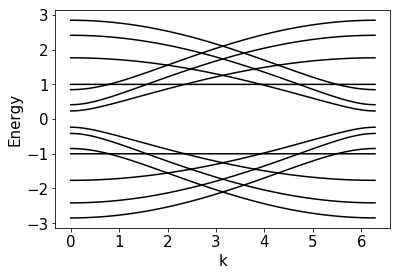

In [4]:
from Zak_compute import zak_bands
[tempm,wf]=zak_bands(Zigzag_1d.finalized(),momenta=101)

## Z2 pack code

In [20]:
import z2pack
from Z2_compute import zak_bands as zak_bands_z2
ham_k=zak_bands_z2(Zigzag_1d.finalized(),momenta=100001,dim=1)
z2_system = z2pack.hm.System(ham_k,dim=1)
z2_sum = 0 
result = z2pack.line.run(system=z2_system, line=lambda t1: [t1]);
#np.exp(-1*2*np.pi*np.sum(np.log(np.diagonal(result.wilson))))
#result.pol
#z2pack.invariant.z2(result)


+----------------------------------------------------------------------+
|        ================                                              |
|        LINE CALCULATION                                              |
|        ================                                              |
|        starting at 2019-01-29 12:44:53,479                           |
|        running Z2Pack version 2.1.1                                  |
|                                                                      |
|        init_result: None                                             |
|        iterator:    range(8, 27, 2)                                  |
|        line:        <function <lambda> at 0x113a12f28>               |
|        load:        False                                            |
|        load_quiet:  True                                             |
|        pos_tol:     0.01                                             |
|        save_file:   None                        

In [19]:
np.exp(-1j*2*np.pi*np.imag(np.sum(np.log(np.diagonal(result.wilson)))))

(1+1.2088337529100796e-15j)

In [7]:
for i in range(0,N+1):
    result = z2pack.line.run(system=z2_system, line=lambda t1: [t1*2-1,i/(N+1)*2-1,0]);
    result.gap_pos
    result.pol
    z2_sum += z2pack.invariant.z2(result)
print(z2_sum)

NameError: name 'N' is not defined

In [ ]:
z2_system.get_eig

In [15]:
num_kpoints = np.shape(wf)[0]
num_bands = np.shape(wf)[1] 
num_basis = np.shape(wf)[2] 
dk = np.linspace(-np.pi,np.pi,num_kpoints)[0]
gamma_n = [] 
for n in range(num_bands):
    gamma = 1
    for k0 in range(num_kpoints-1):
        if k0+1 == num_kpoints: 
            k1=0
        else:
            k1 = k0 + 1 
        u_nk0 = wf[k0][n,:]
        u_nk1 = wf[k1][n,:]
        bra_unk = np.transpose(np.conj(u_nk0))
        #bra_unk = np.matrix.getH(u_nk0)
        gamma = gamma*np.inner(bra_unk,u_nk1)
    gamma_n.append(gamma)
np.exp(-1j*np.imag(np.sum(np.log(gamma_n)))) 

(0.5402005004453851-0.8415363446212858j)

In [17]:
np.imag(np.sum(np.log(gamma_n)))

7.283306287547111

In [18]:
np.imag(np.sum(np.log(np.diagonal(result.wilson))))

-1.9239186715196597e-16

In [5]:
ham_k([0])

NameError: name 'ham_k' is not defined